# Deep Deterministic Policy Gradient for Portfolio Management

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [1]:
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3

In [4]:
# get target history
target_stocks = ['AAPL', 'COST', 'DISH']
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

In [5]:
# collect testing data
testing_stocks = ['CMCSA', 'GOOGL', 'EBAY']
testing_history = np.empty(shape=(len(testing_stocks), num_testing_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), :num_testing_time, :]

In [6]:
# dataset for 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [7]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(16, 1095, 4)
(16, 730, 4)


In [8]:
# visualize 3 stock open price
if False:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()

In [9]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

Using Theano backend.


In [10]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [11]:
models = []
model_names = []
window_length_lst = [3, 7, 14, 21]
predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [12]:
for window_length in window_length_lst:
    name = 'imit_LSTM%3A window = {}'.format(window_length)
    model_name = 'imitation_lstm_window_{}'.format(window_length)
    model_names.append(model_name)
    # instantiate LSTM model
    lstm_model = StockLSTM(nb_classes, window_length, weights_file = 'weights/' + name + '.h5')
    lstm_model.build_model(load_weights=True)
    models.append(lstm_model)
    
    name = 'imit_CNN%3A window = {}'.format(window_length)
    model_name = 'imitation_cnn_window_{}'.format(window_length)
    model_names.append(model_name)
    # instantiate CNN model
    cnn_model = StockCNN(nb_classes, window_length, weights_file = 'weights/' + name + '.h5')
    cnn_model.build_model(load_weights=True)
    models.append(cnn_model)

Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model


In [13]:
# instantiate environment, 3 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


[2017-11-27 20:57:46,573] From /Applications/anaconda/lib/python2.7/site-packages/tflearn/initializations.py:119: __init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt


[2017-11-27 20:57:53,112] Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt


[2017-11-27 20:58:01,136] Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt


[2017-11-27 20:58:08,491] Restoring parameters from weights/stock/cnn/window_7/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt


[2017-11-27 20:58:18,485] Restoring parameters from weights/stock/lstm/window_7/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt


[2017-11-27 20:58:28,471] Restoring parameters from weights/stock/cnn/window_14/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_14/batch_norm/checkpoint.ckpt


[2017-11-27 20:58:40,669] Restoring parameters from weights/stock/lstm/window_14/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_21/batch_norm/checkpoint.ckpt


[2017-11-27 20:58:51,096] Restoring parameters from weights/stock/cnn/window_21/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_21/batch_norm/checkpoint.ckpt


[2017-11-27 20:59:04,904] Restoring parameters from weights/stock/lstm/window_21/batch_norm/checkpoint.ckpt


In [14]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:8], steps=365)

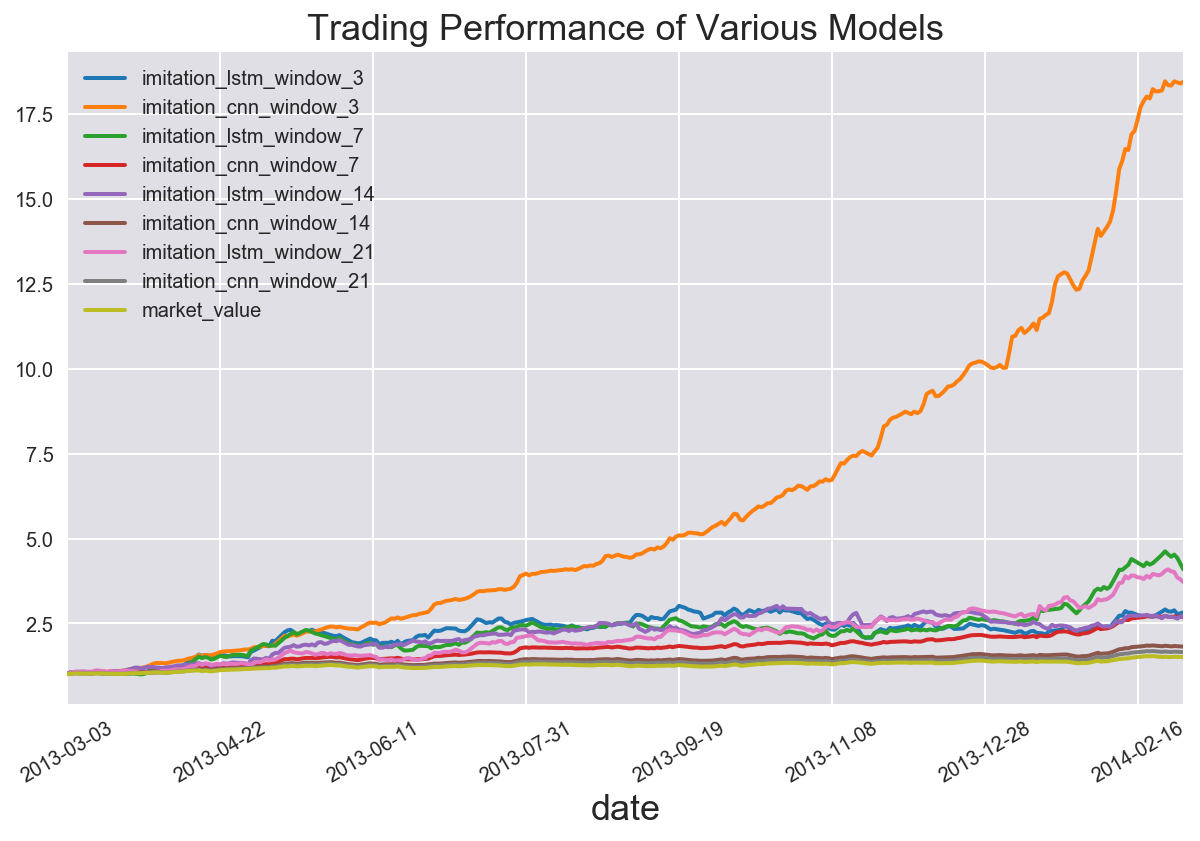

In [15]:
test_model_multiple(env, models[:8])

In [16]:
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[8:], steps=365)

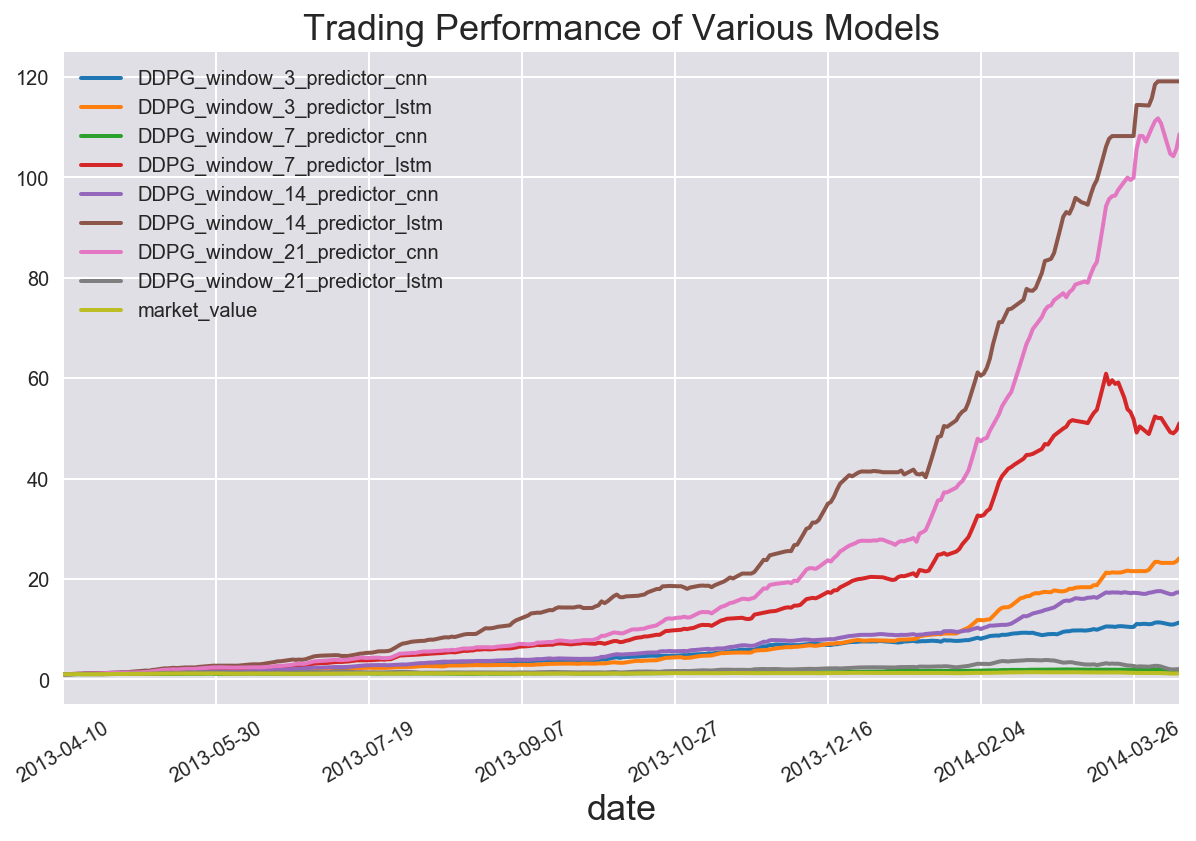

In [17]:
test_model_multiple(env, models[8:])

In [20]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:8], steps=650, start_idx=num_training_time, 
                   sample_start_date=None)

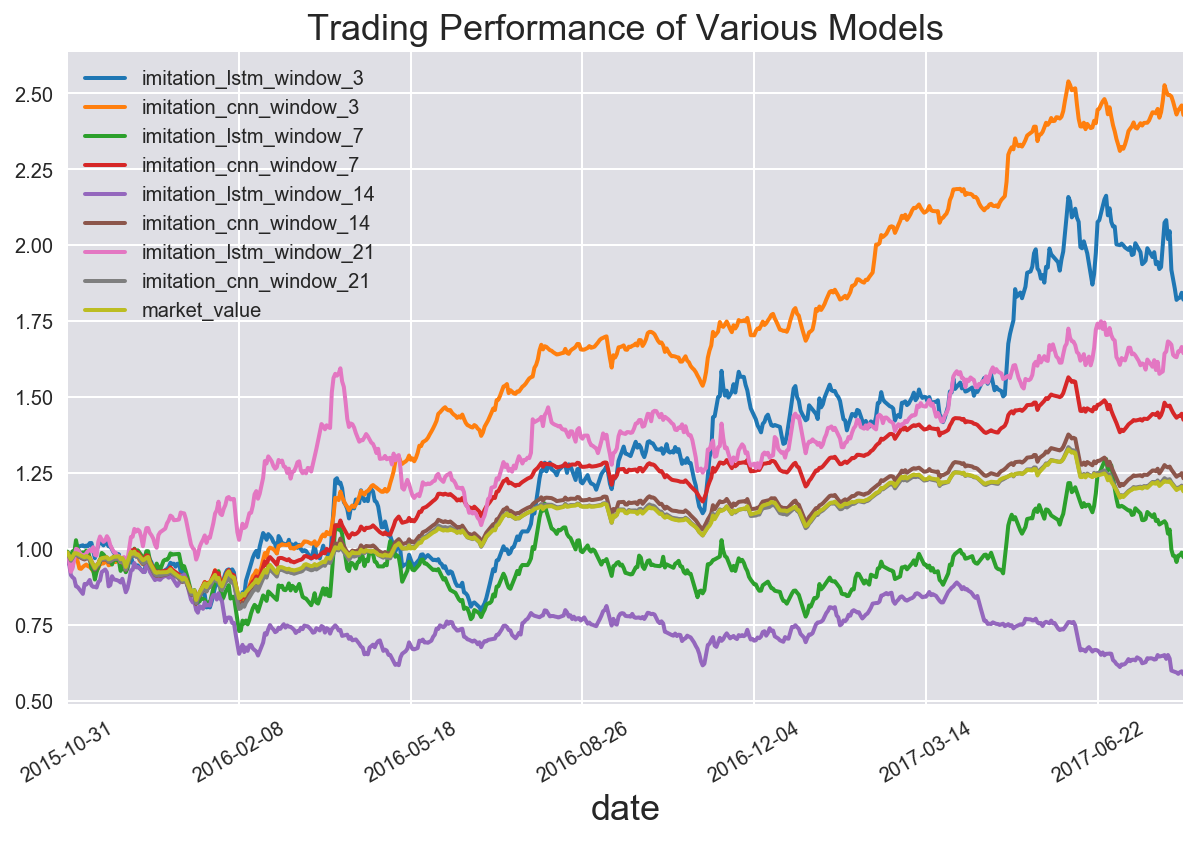

In [21]:
# test on CNN predictor, with batch norm and window length of 3
test_model_multiple(env, models[:8])

In [22]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[8:], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

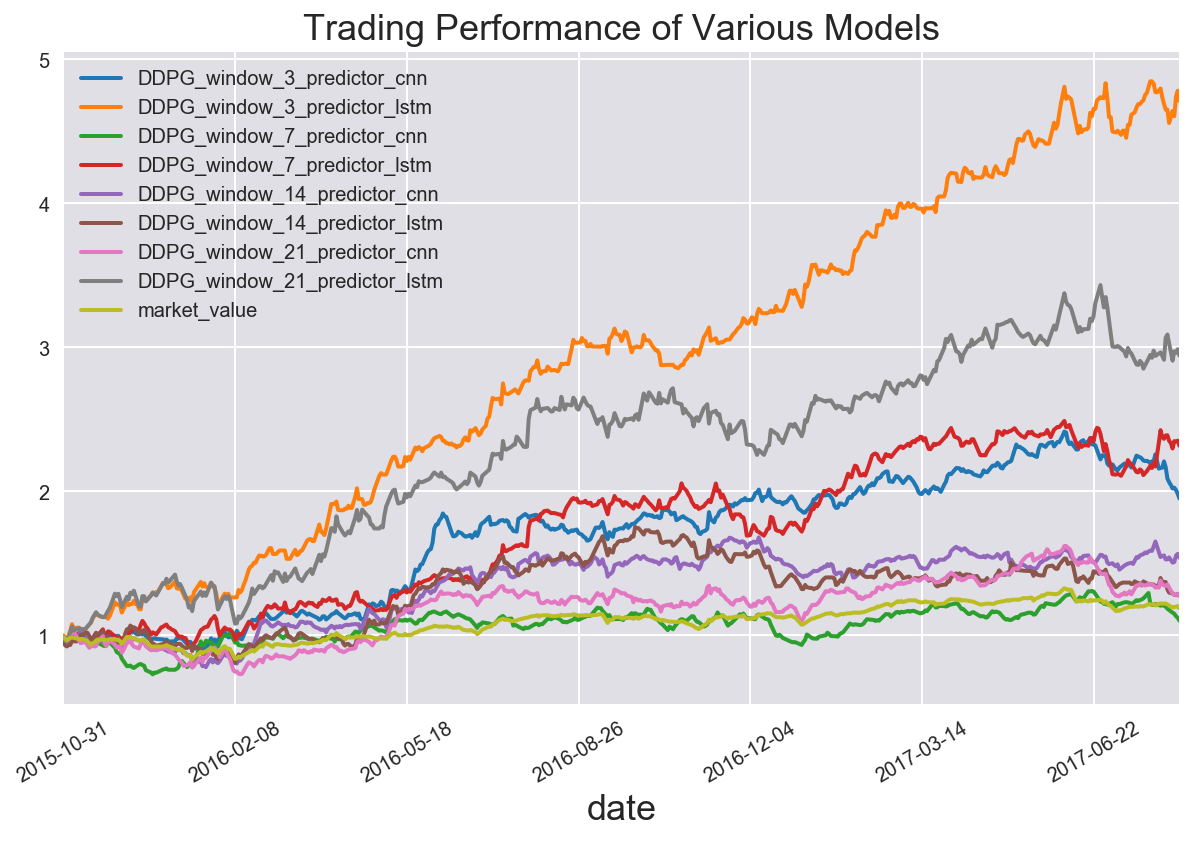

In [23]:
test_model_multiple(env, models[8:])

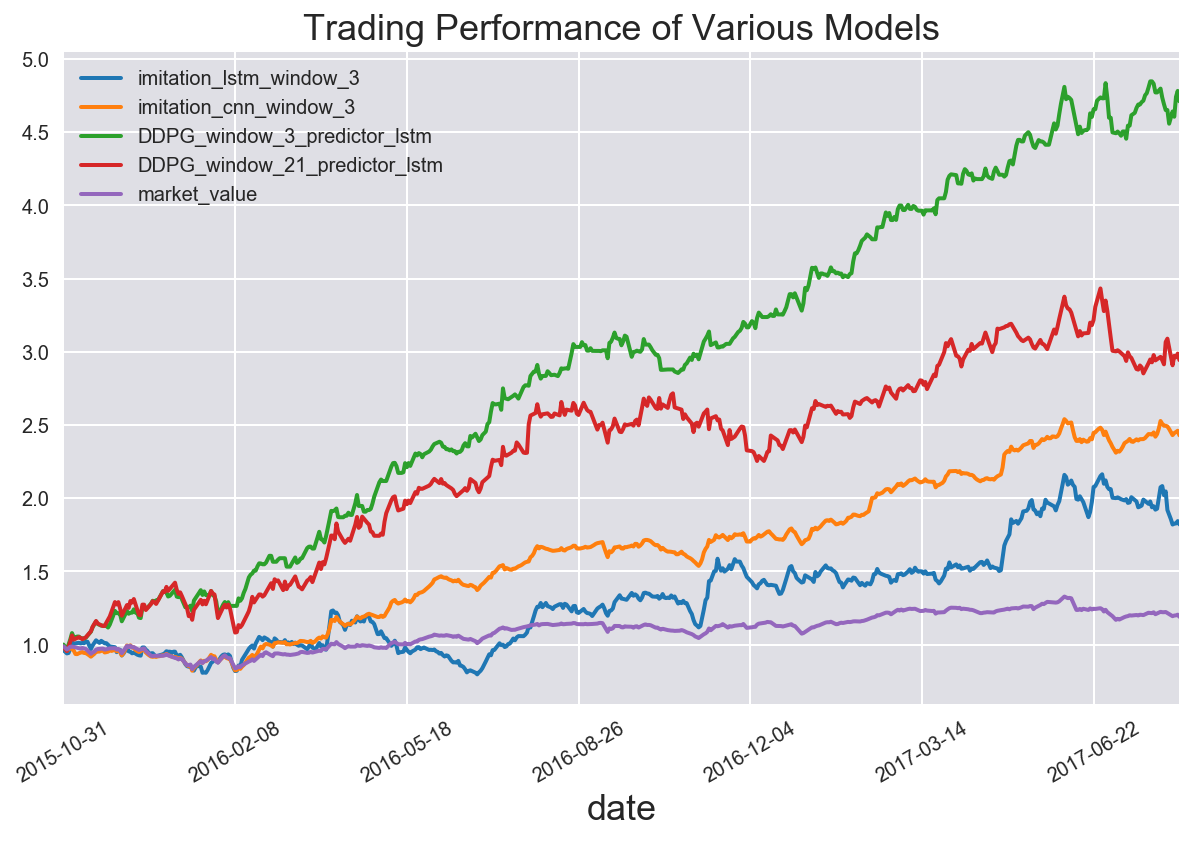

In [27]:
from environment.portfolio import MultiActionPortfolioEnv
selected_models = [models[0], models[1], models[9], models[15]]
selected_model_names = [model_names[0], model_names[1], model_names[9], model_names[15]]
env = MultiActionPortfolioEnv(testing_history, testing_stocks, selected_model_names, steps=650, 
                              start_idx=num_training_time, sample_start_date='2015-10-30')
test_model_multiple(env, selected_models)

In [28]:
from model.supervised.imitation_optimal_action import *

In [29]:
# test on imitation learning
optimal_given_past_model = create_network_give_past(nb_classes, 3, 
                                        weight_path='weights/stock/imitation_16_stocks.h5')

Model load successfully


In [30]:
env = PortfolioEnv(testing_history, testing_stocks, steps=365, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

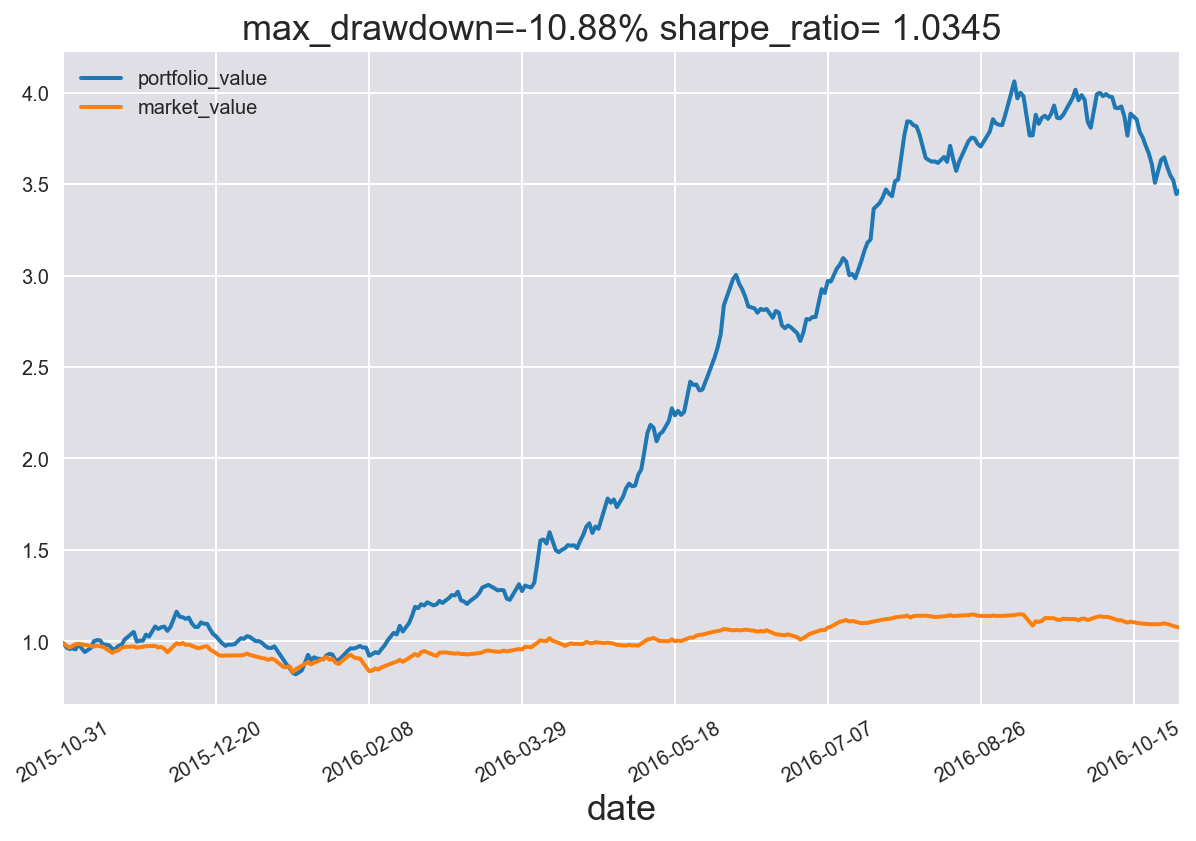

In [31]:
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.zeros((nb_classes,))
    close_open_ratio = close_open_ratio[:, -3:]
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = 1.0
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()